<a href="https://colab.research.google.com/github/hgene0929/deep_learning/blob/main/test_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow Object Detection API 설치하기

In [ ]:
import os
import pathlib

# models 폴더가 존재하지 않는다면 git clone으로 models repository를 다운로드 받습니다.
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone https://github.com/tensorflow/models
  %cd models
  #!git reset --hard d7ce106b8ea449cc629569ca43a95e55a18807fa  # 안정적인 version의 commit으로 reset
  %cd ..

In [ ]:
# TensorFlow Object Detection API를 설치합니다.
# Reference : https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2.md 
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install --upgrade pip
python -m pip install --use-feature=2020-resolver .

관련 라이브러리 import 하기

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [5]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [6]:
# path 경로에서 이미지를 읽어서 numpy array 형태로 반환합니다.
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

TensorFlow Model ZOO 전체 model list
Reference : https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

In [9]:
# faster r-cnn 모델을 불러옵니다. 다른 모델 사용할 경우, 위의 git 파일에서 사용할 모델의 링크 주소를 복사하여 전체 이름을 넣으면 된다.
model_name = 'faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8'

In [ ]:
# ms coco dataset에 학습된 fasterrcnn의 checkpoint 파일을 다운로드하고 압축을 풉니다.
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8.tar.gz
!tar -xf faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8.tar.gz
# 해당 checkpoint 파일을 models/research/object_detection/test_data/ 경로로 옮깁니다.
!mv faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

In [10]:
# config 파일과 checkpoint 파일의 경로를 설정합니다.
pipeline_config = os.path.join('models/research/object_detection/configs/tf2/', model_name + '.config')
model_dir = 'models/research/object_detection/test_data/checkpoint/'

# config파일을 이용해서 모델 인스턴스를 생성합니다.
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# checkpoint 파일로부터 파라미터를 복원합니다.
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

# model의 예측 결과를 받아옵니다.
def get_model_detection_function(model):
  """Get a tf.function for detection."""

  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [11]:
# ms coco 레이블들을 읽어옵니다.
LABEL_MAP_PATH = 'models/research/object_detection/data/mscoco_label_map.pbtxt'

label_map_path = LABEL_MAP_PATH
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

MS COCO 데이터셋의 80개 레이블

Reference : https://gist.github.com/AruniRC/7b3dadd004da04c80198557db5da4bda

In [ ]:
categories

Instructions for updating:
Use ref() instead.


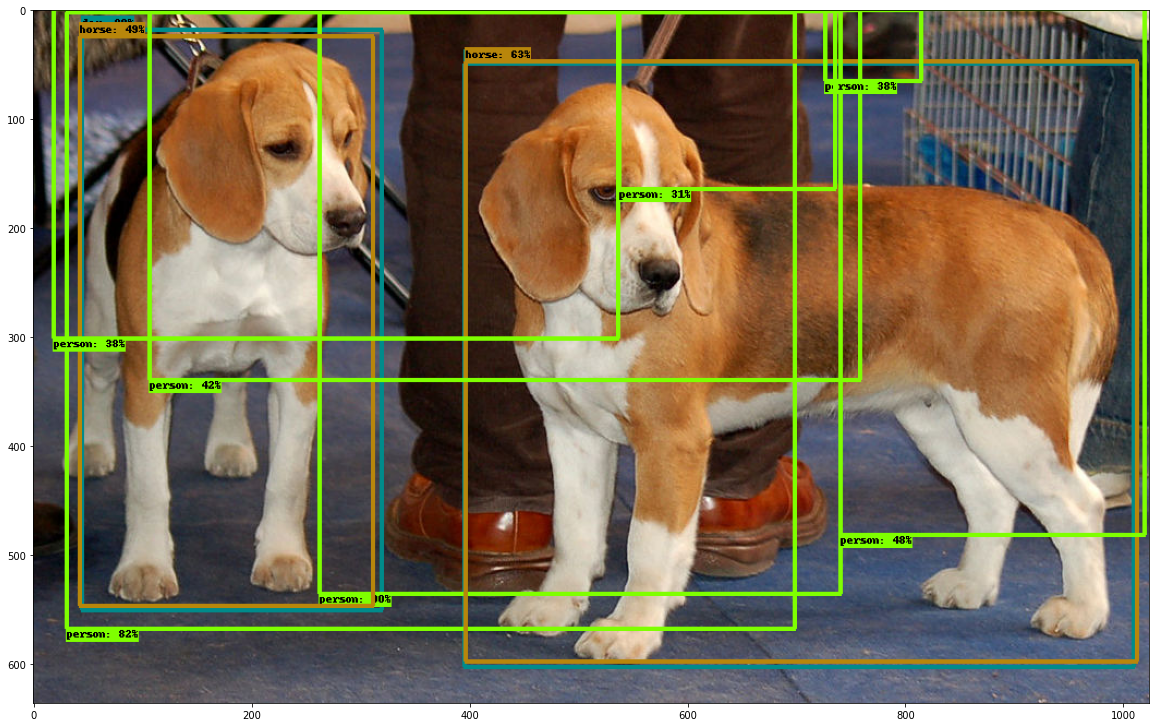

In [14]:
# 이미지 파일 경로에서 테스트 이미지를 np.array 형태로 읽어옵니다.
image_dir = 'models/research/object_detection/test_images/'
image_path = os.path.join(image_dir, 'image1.jpg')
image_np = load_image_into_numpy_array(image_path)

# 이미지에 대한 예측을 수행합니다.
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

# image_np_with_detections np.array에 시각화 결과를 반환합니다.
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False
      )

plt.figure(figsize=(20,20))
plt.imshow(image_np_with_detections)
plt.show()

confidence threshold 조정하기 (이미지 검출 정확도 높이기)

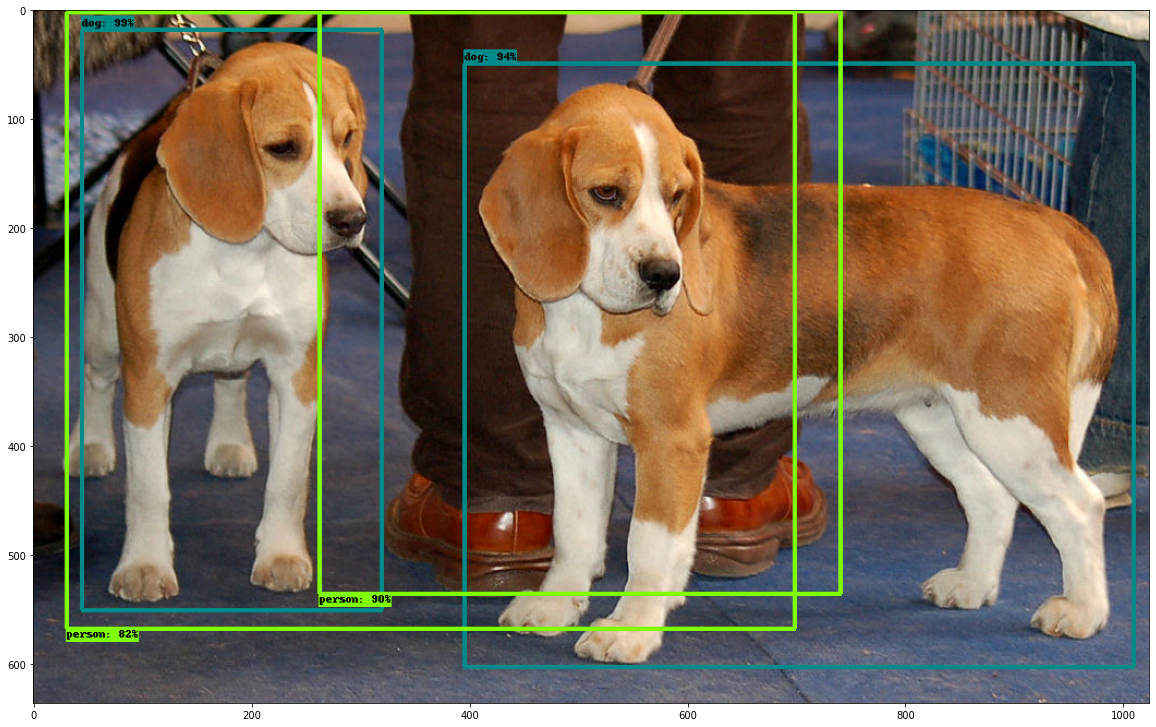

In [15]:
image_dir = 'models/research/object_detection/test_images/'
image_path = os.path.join(image_dir, 'image1.jpg')
image_np = load_image_into_numpy_array(image_path)

# 이미지에 대한 예측을 수행합니다.
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

# confidence threshold를 0.7로 높여서 더 정확한 Bounding box 출력결과만 화면에 그립니다.
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.70,
      agnostic_mode=False
      )

plt.figure(figsize=(20,20))
plt.imshow(image_np_with_detections)
plt.show()

Person Detection - 사람 이미지에 대한 detection 결과 테스트하기

In [16]:
!pwd

/content


아래 경로에서 pedestrian 데이터를 다운로드 받습니다.

Reference :

https://www.kaggle.com/alincijov/penn-fudan?select=readme.txt

https://www.cis.upenn.edu/~jshi/ped_html/

In [ ]:
!unzip archive.zip

In [ ]:
image_dir = 'PNGImages/'
image_path = os.path.join(image_dir, 'FudanPed00001.png')
image_np = load_image_into_numpy_array(image_path)

# 이미지에 대한 예측을 수행합니다.
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

# image_np_with_detections np.array에 시각화 결과를 반환합니다.
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False
      )

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

In [ ]:
image_dir = 'PNGImages/'
image_path = os.path.join(image_dir, 'FudanPed00005.png')
image_np = load_image_into_numpy_array(image_path)

# 이미지에 대한 예측을 수행합니다.
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

# image_np_with_detections np.array에 시각화 결과를 반환합니다.
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False
      )

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()